In [1]:
import os
import re
import subprocess
import pickle
from collections import Counter
import chardet

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from nltk.corpus import stopwords
from collections import namedtuple
from sklearn.naive_bayes import GaussianNB
from nltk import NaiveBayesClassifier

from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

import gensim
import os
import collections
import smart_open
import random

from sklearn.model_selection import train_test_split

TopicProcess = namedtuple('TopicProcess', ['model', 'vectorizer', 'training_vectors'])

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### Load data from all_books.pkl

In [2]:
with open('all_books.pkl', 'rb') as file: 
    all_books = pickle.load(file)

In [3]:
books = [book for book in all_books.keys()]

Labeling authors

In [4]:
def extract_all(author_list, all_books):
    books_author = []
    author_data = []
    y_author = []
    books = [book for book in all_books.keys()]
    for label, author in enumerate(author_list):
        books_author =[]
        for book in books:
            if author in book:
                books_author.append(book)
        for book in books_author:
            entries_book= all_books[book]
            for entry in entries_book:
                author_data.append(entry)
                y_author.append(label)
    return author_data, y_author

In [5]:
all_authors = ["Benito_Pérez_Galdos","Emilia_Pardo_Bazán",  "Juan_Valera", "Leopoldo_Alas_Clarín", 
               "Miguel_de_Unamuno", "Ramón_del_Valle_Inclán", "Vicente_Blasco_Ibáñez", "Pío_Baroja"]

In [6]:
all_authors_data, y_author = extract_all(all_authors, all_books)

In [7]:
len(all_authors_data)

45961

In [8]:
Counter(y_author)

Counter({0: 20566,
         1: 6765,
         2: 906,
         3: 2591,
         4: 1584,
         5: 1612,
         6: 567,
         7: 11370})

Extract some authors

In [9]:
def extract_author(all_data, y_data, label_authors):
    data_selected = []
    labels_selected = []
    for label, fragment in zip(y_data, all_data):
        if label in label_authors:
            data_selected.append(fragment)
            labels_selected.append(label)
    return data_selected, labels_selected

In [10]:
selected_data, y_selected = extract_author(all_authors_data, y_author, [0,7])
len(selected_data)

31936

### Vectorizing the data

In [11]:
stop = stopwords.words('spanish')
stop += ['.', ',', '(', ')', "'", '"', "-"]
stop = set(stop)

In [12]:
len(all_authors_data)

45961

In [13]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

incorporating vectorization and dimensionality reduction in a single function. The output is a named tuple with model vectorizer and training method.

In [14]:
def vectorization_reduction(data, stop, vec, dim_red, n_comp, ngram_min, ngram_max, max_freq): 
    count_vectorizer = CountVectorizer(ngram_range=(ngram_min, ngram_max),  
                                       stop_words=stop, 
                                       token_pattern="\\b[a-z][a-z]+\\b",
                                       lowercase=True,
                                       max_df = max_freq)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(ngram_min, ngram_max),  
                                       stop_words=stop, 
                                       token_pattern="\\b[a-z][a-z]+\\b",
                                       lowercase=True,
                                       max_df = max_freq)
    cv_data = count_vectorizer.fit_transform(data)
    tfidf_data = tfidf_vectorizer.fit_transform(data)
    if vec=="count" and dim_red=="LSA":
        lsa_cv = TruncatedSVD(n_components=n_comp)
        lsa_cv_data = lsa_cv.fit_transform(cv_data)
        return TopicProcess(model=lsa_cv, vectorizer=count_vectorizer, training_vectors=lsa_cv_data)
    if vec=="count" and dim_red=="NMF":
        nmf_cv = NMF(n_components=n_comp)
        nmf_cv_data = nmf_cv.fit_transform(cv_data)
        return TopicProcess(model=nmf_cv, vectorizer=count_vectorizer, training_vectors=nmf_cv_data)
    if vec=="tfidf" and dim_red=="LSA":
        lsa_tfidf = TruncatedSVD(n_components=n_comp)
        lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
        return TopicProcess(model=lsa_tfidf, vectorizer=tfidf_vectorizer, training_vectors=lsa_tfidf_data)

In [16]:
process_lsa_tfidf = vectorization_reduction(all_authors_data, stop, vec="tfidf", dim_red="LSA", n_comp=10, ngram_min=1, ngram_max=3, max_freq=0.2)

In [87]:
model = TSNE(n_components=2, random_state=0, verbose=2)
low_data = model.fit_transform(process_lsa_tfidf.training_vectors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 45961 samples in 0.068s...
[t-SNE] Computed neighbors for 45961 samples in 21.524s...
[t-SNE] Computed conditional probabilities for sample 1000 / 45961
[t-SNE] Computed conditional probabilities for sample 2000 / 45961
[t-SNE] Computed conditional probabilities for sample 3000 / 45961
[t-SNE] Computed conditional probabilities for sample 4000 / 45961
[t-SNE] Computed conditional probabilities for sample 5000 / 45961
[t-SNE] Computed conditional probabilities for sample 6000 / 45961
[t-SNE] Computed conditional probabilities for sample 7000 / 45961
[t-SNE] Computed conditional probabilities for sample 8000 / 45961
[t-SNE] Computed conditional probabilities for sample 9000 / 45961
[t-SNE] Computed conditional probabilities for sample 10000 / 45961
[t-SNE] Computed conditional probabilities for sample 11000 / 45961
[t-SNE] Computed conditional probabilities for sample 12000 / 45961
[t-SNE] Computed conditional probabilities for sa

Taking a look a the distribution of fragments after t-SNE

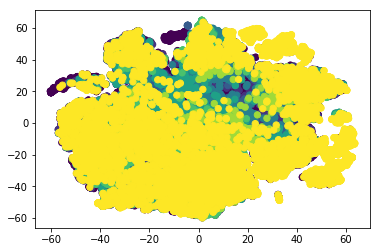

In [88]:
x,y = zip(*low_data)
plt.scatter(x,y,c=y_author,s=40)

### Clustering the authors ( tfidf-LSA vectorization)  

In [26]:
process_lsa_tfidf = vectorization_reduction(all_authors_data, stop, vec="tfidf", dim_red="LSA", n_comp=5, ngram_min=1, ngram_max=3, max_freq=0.3)

##### Using Kmeans

In [17]:
def kmeans_fit(data, y_author, k_min, k_max):
    cluster_author = []
    inertias = []
    for k in range(k_min,k_max+1):
        km = KMeans(n_clusters=k)
        km.fit(data)
        labels = km.labels_
        inertias.append(km.inertia_) 
        for index in range(data.shape[0]):
            cluster_author.append(["k="+str(k), labels[index], y_author[index]])
    return cluster_author, inertias

In [28]:
k_min = 2
k_max = 20
cluster_author, inertias = kmeans_fit(process_lsa_tfidf.training_vectors, y_author, k_min, k_max)

Inertia plot vs number of clusters

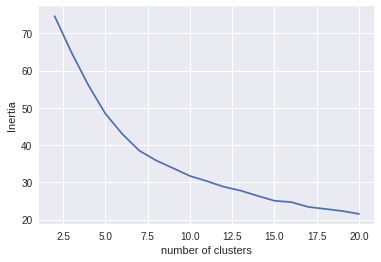

In [29]:
k_clusters = range(k_min, k_max+1)
plt.plot(k_clusters, inertias)
plt.xlabel('number of clusters')
plt.ylabel('Inertia');

It looks like there is a corner for k~7.  
Plotting the clusters for k=6 and getting the proportion of each authors corpus for a each cluster.

In [30]:
cluster_author, inertias = kmeans_fit(process_lsa_tfidf.training_vectors, y_author, 6, 6)

In [31]:
dictio_clusters = Counter( ["Cluster:" + str(cluster) + "; Author:" + str(author) for k, cluster, author in cluster_author] )
dictio_clusters

Counter({'Cluster:0; Author:0': 4835,
         'Cluster:0; Author:1': 1901,
         'Cluster:0; Author:2': 356,
         'Cluster:0; Author:3': 966,
         'Cluster:0; Author:4': 481,
         'Cluster:0; Author:5': 68,
         'Cluster:0; Author:6': 201,
         'Cluster:0; Author:7': 243,
         'Cluster:1; Author:0': 2563,
         'Cluster:1; Author:1': 754,
         'Cluster:1; Author:2': 38,
         'Cluster:1; Author:3': 179,
         'Cluster:1; Author:4': 88,
         'Cluster:1; Author:5': 59,
         'Cluster:1; Author:6': 14,
         'Cluster:1; Author:7': 1158,
         'Cluster:2; Author:0': 4117,
         'Cluster:2; Author:1': 150,
         'Cluster:2; Author:2': 66,
         'Cluster:2; Author:3': 114,
         'Cluster:2; Author:4': 117,
         'Cluster:2; Author:5': 21,
         'Cluster:2; Author:6': 13,
         'Cluster:2; Author:7': 1165,
         'Cluster:3; Author:0': 8485,
         'Cluster:3; Author:1': 3713,
         'Cluster:3; Author:2': 329,
 

In [32]:
list_for_graph = []
for cluster in range(6):
    list_cluster = []
    for author in range(8):
        list_cluster.append(dictio_clusters["Cluster:"+str(cluster)+"; Author:"+str(author)]/Counter(y_author)[author])
    list_for_graph.append(list_cluster)
 

In [33]:
list_for_graph[0]

[0.23509676164543422,
 0.2810051736881005,
 0.39293598233995586,
 0.3728290235430336,
 0.3036616161616162,
 0.04218362282878412,
 0.3544973544973545,
 0.021372031662269128]

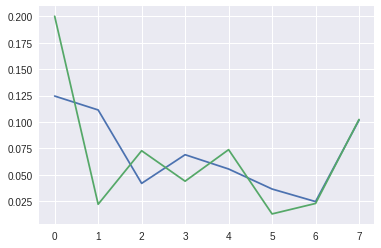

In [34]:
plt.plot(
#         range(8), list_for_graph[0], 
         range(8), list_for_graph[1], 
         range(8), list_for_graph[2], 
#         range(8), list_for_graph[3], 
#         range(8), list_for_graph[4], 
#         range(8), list_for_graph[5], 
);

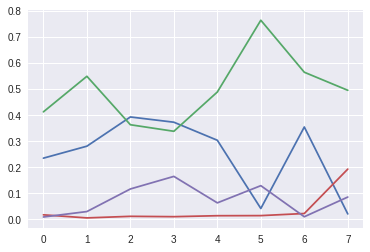

In [35]:
plt.plot(
         range(8), list_for_graph[0], 
#         range(8), list_for_graph[1], 
#         range(8), list_for_graph[2], 
         range(8), list_for_graph[3], 
         range(8), list_for_graph[4], 
         range(8), list_for_graph[5], 
);

Plotting the clusters for k=5

In [40]:
cluster_author, inertias = kmeans_fit(process_lsa_tfidf.training_vectors, y_author, 5, 5)

In [41]:
dictio_clusters = Counter( ["Cluster:" + str(cluster) + "; Author:" + str(author) for k, cluster, author in cluster_author] )

In [42]:
list_for_graph = []
for cluster in range(5):
    list_cluster = []
    for author in range(8):
        list_cluster.append(dictio_clusters["Cluster:"+str(cluster)+"; Author:"+str(author)]/Counter(y_author)[author])
    list_for_graph.append(list_cluster)

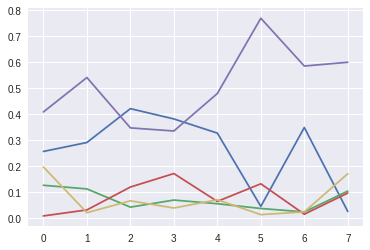

In [43]:
plt.plot(
         range(8), list_for_graph[0], 
         range(8), list_for_graph[1], 
         range(8), list_for_graph[2], 
         range(8), list_for_graph[3], 
         range(8), list_for_graph[4], 
);

Plotting the clusters for k=7

In [45]:
cluster_author, inertias = kmeans_fit(process_lsa_tfidf.training_vectors, y_author, 7, 7)

In [46]:
dictio_clusters = Counter( ["Cluster:" + str(cluster) + "; Author:" + str(author) for k, cluster, author in cluster_author] )

In [49]:
list_for_graph = []
for cluster in range(8):
    list_cluster = []
    for author in range(8):
        list_cluster.append(dictio_clusters["Cluster:"+str(cluster)+"; Author:"+str(author)]/Counter(y_author)[author])
    list_for_graph.append(list_cluster)

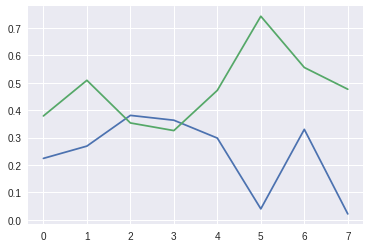

In [72]:
plt.plot(
#         range(8), list_for_graph[0], 
         range(8), list_for_graph[1], 
         range(8), list_for_graph[2], 
#         range(8), list_for_graph[3], 
#         range(8), list_for_graph[4], 
#         range(8), list_for_graph[5], 
#         range(8), list_for_graph[6], 
);

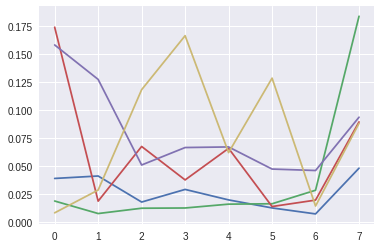

In [57]:
plt.plot(
         range(8), list_for_graph[0], 
#         range(8), list_for_graph[1], 
#         range(8), list_for_graph[2], 
         range(8), list_for_graph[3], 
         range(8), list_for_graph[4], 
         range(8), list_for_graph[5], 
         range(8), list_for_graph[6], 
);

##### DBSCAN (IT CRASHES!!, not enough memory(?))

In [ ]:
db = DBSCAN(eps=0.15, min_samples=3).fit(process_lsa_tfidf.training_vectors)
labels = db.labels_

In [ ]:
def DBSCAN_fit(data, y_author, eps_min=0.15, min_samples=3):
    db = DBSCAN(eps=0.15, min_samples=3).fit(process_lsa_tfidf.training_vectors)
    labels = db.labels_        
    inertias.append([eps, min_samples, db.inertia_]) 
    return inertias

### Now with 30 components for the vectorization

In [15]:
process_lsa_tfidf = vectorization_reduction(all_authors_data, stop, vec="tfidf", dim_red="LSA", 
                                            n_comp=30, ngram_min=1, ngram_max=3, max_freq=0.3)

In [18]:
k_min = 2
k_max = 11
cluster_author, inertias = kmeans_fit(process_lsa_tfidf.training_vectors, y_author, k_min, k_max)

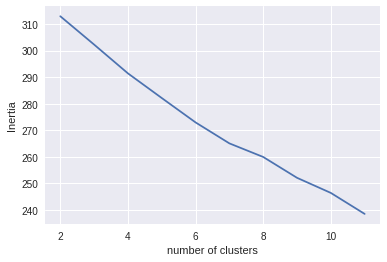

In [19]:
k_clusters = range(k_min, k_max+1)
plt.plot(k_clusters, inertias[:21])
plt.xlabel('number of clusters')
plt.ylabel('Inertia');

No clear kink

In [20]:
cluster_author, inertias = kmeans_fit(process_lsa_tfidf.training_vectors, y_author, 6, 6)

In [21]:
dictio_clusters = Counter( ["Cluster:" + str(cluster) + "; Author:" + str(author) for k, cluster, author in cluster_author] )

In [22]:
list_for_graph = []
for cluster in range(7):
    list_cluster = []
    for author in range(8):
        list_cluster.append(dictio_clusters["Cluster:"+str(cluster)+"; Author:"+str(author)]/Counter(y_author)[author])
    list_for_graph.append(list_cluster)

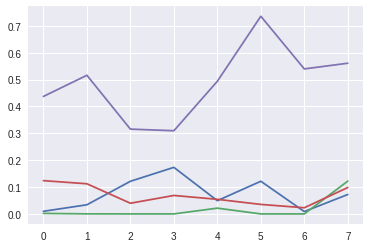

In [23]:
plt.plot(
#         range(8), list_for_graph[0], 
         range(8), list_for_graph[1], 
         range(8), list_for_graph[2], 
         range(8), list_for_graph[3], 
         range(8), list_for_graph[4], 
#         range(8), list_for_graph[5], 
);

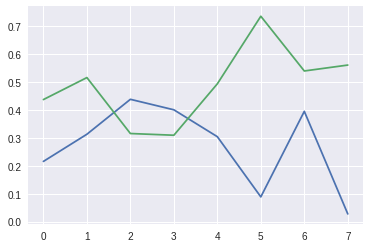

In [29]:
plt.plot(
         range(8), list_for_graph[0], 
#         range(8), list_for_graph[1], 
#         range(8), list_for_graph[2], 
#         range(8), list_for_graph[3], 
         range(8), list_for_graph[4], 
#         range(8), list_for_graph[5], 
);